**17_MAW_ii**

In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  
from flopy.plot.styles import styles ; import shapefile as shp ; import matplotlib as mpl ; import pandas as pd
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)

In [2]:
sim_ws       = Path("./17_MAW_ii")                          ; sim_ws.mkdir(exist_ok=True)    ; name = sim_name = "ex-gwf-maw-p02"
exe_name     = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'      ; workspace = figs_path = sim_ws ; gwf_name = sim_name ; out_f = sim_ws

In [3]:
botm_str="-142.9,-514.5";botm=[float(value)for value in botm_str.split(",")]  ;strt_str="3.05,9.14";strt=[float(value)for value in strt_str.split(",")]

length_units = "meters" ; time_units = "days"               ; nlay = 2 ;nrow = 101 ;ncol = 101 ;delr = 142 ;delc = 142 ;top = -50 ;
k11 = 1 ;k33 = 0.0000000000000001 ;ss = 0.0001              ; maw_radius = 0.15  ; maw_rate = 0               ; tdis_ds = ((2.314815, 50, 1.2),)
nouter = 500 ;ninner = 100                                  ; hclose = 0.000000001 ;rclose = 0.0001           ; nper = 1                      
extents = (0.0, delr * ncol, 0.0, delc * nrow)              ; shape2d = (nrow, ncol)  ; shape3d = (nlay, nrow, ncol)
idomain = np.ones(shape3d, dtype=float)                     ; xw, yw = (ncol / 2) * delr, (nrow / 2) * delc   ; y = 0.0
for i in range(nrow):
    x = 0.0 ; y = (float(i) + 0.5) * delc
    for j in range(ncol):
        x = (float(j) + 0.5) * delr    ; r = np.sqrt((x - xw) ** 2.0 + (y - yw) ** 2.0)
        if r > 7163.0:                 idomain[:, i, j] = 0
maw_packagedata = [[0, maw_radius, botm[-1], strt[-1], "SPECIFIED", 2]]          ; maw_row = int(nrow / 2)  ; maw_col = int(ncol / 2)   
maw_conn = [[0, 0, 0, maw_row, maw_col, top, botm[-1], 111.3763, -999.0],[0, 1, 1, maw_row, maw_col, top, botm[-1], 445.9849, -999.0]]
maw_spd  = [[0, "rate", maw_rate], [0, "flowing_well", 0.0, 7500.0, 0.5]]   

In [4]:
print("SPECIFIED_Filter_maw_conn_elevation (value*-1)",maw_conn)

SPECIFIED_Filter_maw_conn_elevation (value*-1) [[0, 0, 0, 50, 50, -50, -514.5, 111.3763, -999.0], [0, 1, 1, 50, 50, -50, -514.5, 445.9849, -999.0]]


In [5]:
np.savetxt(out_f / "01_maw_packagedata.csv" , maw_packagedata   , fmt ="%s", delimiter=",") 
np.savetxt(out_f / "02_maw_conn.csv" ,maw_conn ,delimiter=",")  ; sa = pd.DataFrame(idomain[0,:,:]);sa.to_csv (out_f/"03_idomain.csv") 
obs_dict = [("head" ,"head" ,(0 ,))         ,("Q1" ,"maw" ,(0,) ,(0,)) ,("Q2" ,"maw" ,(0,) ,(1,)),("FW", "fw-rate", (0,))]
ab=pd.DataFrame(obs_dict) ; ab.to_csv(out_f/"04_obs_dict.csv")  

In [6]:
def build_models():
    obs_file = f"{sim_name}.maw.obs" ; csv_file = obs_file + ".csv"
    obs_dict = {csv_file: [("head", "head", (0,)),("Q1", "maw", (0,), (0,)),("Q2", "maw", (0,), (1,)),("FW", "fw-rate", (0,))]}  
    head_filerecord = f"{sim_name}.hds"    ; budget_filerecord=f"{sim_name}.cbc" 
    
    sim = flopy.mf6.MFSimulation    (sim_name=sim_name,sim_ws=sim_ws,exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim,nper=nper,perioddata=tdis_ds,time_units=time_units)
    flopy.mf6.ModflowIms    (sim,print_option="summary",outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose}strict")
    gwf = flopy.mf6.ModflowGwf      (sim,modelname=sim_name,save_flows=True)
    flopy.mf6.ModflowGwfdis     (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain)
    flopy.mf6.ModflowGwfnpf     (gwf,icelltype=0,k=k11,k33=k33,save_specific_discharge=True)
    flopy.mf6.ModflowGwfsto     (gwf,iconvert=0,ss=ss)
    flopy.mf6.ModflowGwfic      (gwf,strt=strt)
    maw=flopy.mf6.ModflowGwfmaw (gwf,flowing_wells=True,nmawwells=1,packagedata=maw_packagedata,connectiondata=maw_conn,perioddata=maw_spd)
    maw.obs.initialize          (filename= obs_file, digits=10, print_input=True, continuous = obs_dict)
#   flopy.mf6.ModflowGwfoc      (gwf, printrecord=[("BUDGET", "LAST")])
    flopy.mf6.ModflowGwfoc      (gwf ,head_filerecord=head_filerecord ,budget_filerecord=budget_filerecord ,
                                 saverecord=[("HEAD" ,"LAST") ,("BUDGET" ,"LAST")] ,printrecord=[("BUDGET" ,"LAST")])
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write:  write_models(sim, silent=silent)
    if run:    run_models  (sim, silent=silent)
scenario()

run_models took 2713.40 ms


In [7]:
sim_ws2         = Path("17_MAW_ii")      ; sim = build_models()  ;   gwf = sim.get_model(sim_name); extents = gwf.modelgrid.extent

In [8]:
sa0 = pd.read_csv(sim_ws / 'ex-gwf-maw-p02.maw.obs.csv') ;sa0['time']=sa0['time'] * 24 ; sa0.set_index('time', inplace=True, drop=True) 

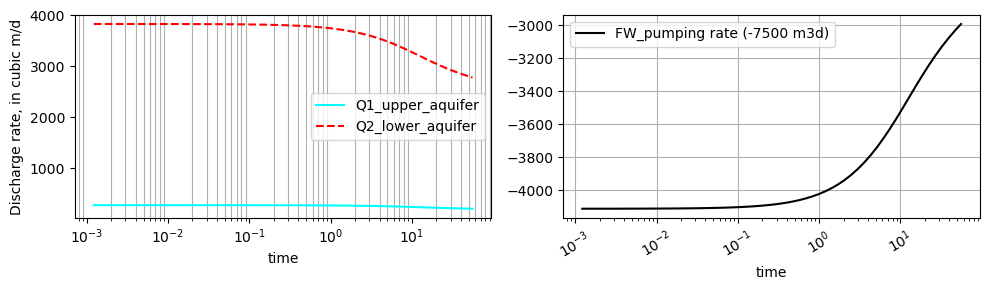

,Heads,Q1_upper_aquifer,Q2_lower_aquifer,FW_pumping rate (-7500 m3d)
time,,,,
26.788679,0.441244,222.110124,2960.865930,-3182.976054
32.147636,0.436542,218.605461,2910.637993,-3129.243455
38.578384,0.432262,215.349030,2864.230597,-3079.579627
46.295282,0.428358,212.329231,2821.388407,-3033.717638
55.555560,0.424775,209.519292,2781.657149,-2991.176442


In [25]:
sa0.columns=['Heads'   , 'Q1_upper_aquifer', 'Q2_lower_aquifer', 'FW_pumping rate (-7500 m3d)'] # FW_pumping rate (-1767 m3d)
fig, ax = plt.subplots(nrows=1, ncols=2)
sa0.plot(ax=ax[0] ,use_index=True,y=['Q1_upper_aquifer','Q2_lower_aquifer'],kind="line", color=['cyan','red'], style=['-', '--'],logx=True)
sa0.plot(ax=ax[1] ,use_index=True, y=['FW_pumping rate (-7500 m3d)'], color=['black'], kind="line", rot=30, figsize=(10,3) , logx=True)  
ax[0].grid('on',which='minor',axis='x') ;ax[0].set_ylabel("Discharge rate, in cubic m/d"); plt.grid()
plt.tight_layout() ; plt.show() ; sa0.tail()